## 第十周: 字詞分類

**Author:** 劉岱宜<br>
**Date created:** 2021/10/01<br>
**Last modified:** 2021/11/21<br>
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用SVC、linear regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用社群媒體上的「塔綠斑」事件的相關文章做示範。

## 大綱
1. 套件說明
2. 文字前處理
    + 2.1 斷句
    + 2.2 斷詞（刪掉次數太少的、標點符號、停用字）
    + 2.3 算出情緒分數，將正負面文章分類
    + 2.4 將情緒標籤加回原本的資料集
    + 2.5 資料集基本檢視
3. 將資料分為測試集和訓練集
    + 3.1 根據7:3的比例切分資料集
4. 將文章轉為 DTM 放入模型訓練
    + 4.1 簡單範例介紹DTM
    + 4.2 套入正式資料集訓練
    + 4.3. 定義建模與畫圖的函數
5. 比較不同模型和資料組合的訓練結果
    + 5.1 logistic regression
    + 5.2 SVC
    + 5.3 decision tree
    + 5.4 預測結果探索

## 分析目標
分析主題：將 ptt八卦版蒐集之文章，利用liwc字典計算情緒分數，分為正面、中性、負面三種標籤，再用線性模型進行文件的情緒分類，希望分析可以獲得以下資訊：
+ 資料內容：
    + 資料來源：ptt 八卦版 (共2426筆)
    + 關鍵字:「塔綠斑」
    + 分類: 正面、中性、負面共三種標籤

1. 兩本小說的字詞分部有甚麼不同，代表字詞有哪些？
    +  討論章節：2.4 資料集基本檢視
        + 斷詞、詞性還原後檢視詞頻
    + 討論章節：5.4.1 各字詞特徵的estimate係數
        + 利用建模後的estimate係數挑選各文集代表字
2. 如果用詞頻建立DTM，需不需要篩選詞頻？
    + 討論章節：4.2 套入正式資料集訓練
        + 比較篩詞頻前後的DTM預測效果
3. 此資料集用什麼樣的模型預測，準確率會較高？
    + 討論章節：5.4.3 比較不同模型的ROC
        + 以不同模型的ROC比較準確率

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具
- time: 獲得目前的時間或作時間格式轉換的工具

In [54]:
import pandas as pd
import re
import time
import string
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import jieba

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

## 2. 文字前處理
`green.csv`裡面包含了要分析的ptt文章資料，在這邊我們先把句子斷開，一個句子代表一個文件(document)，因為每個document需要標上不同的情緒標籤，我們先將每個句子斷詞並用liwc算出情緒分數，為了後面建立 DTM(document-term-matrix) 我們先清理停用字和詞頻太少的句子，並做基本的文件探索。

In [55]:
books = pd.read_csv("raw_data/green.csv") #匯資料
books.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,2021/08/31,16:06:07,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,qweerrt123,Gossiping,9,3,0,這邊就要說啦\n\n其實塔綠班的特性啊\n\n就是越大聲的說就越不會去做啦\n\n看看那個台...
1,[問卦]塔綠班的領導者是「齁里發」嗎？,2021/08/31,16:15:10,https://www.ptt.cc/bbs/Gossiping/M.1630426512....,fraternity,Gossiping,19,13,1,先看一下「哈里發」的定義：\n哈里發本為阿拉伯帝國最高的統治者稱號，相當於一般所說的皇帝，但...
2,Re:[問卦]AZ的發明者是不是應該拿一個諾貝爾？,2021/08/31,16:19:04,https://www.ptt.cc/bbs/Gossiping/M.1630426746....,iloveEG,Gossiping,17,12,2,大家好，我AZ仔\n\n其他行業也是一樣 如果某間公司說要把產品以成本價或是遠低於行情的價格...


In [56]:
# 看看有幾篇文章
print(f"number of posts: {books.shape[0]}")

number of posts: 2426


### 2.文字前處理
+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）
+ 2.3 算出情緒分數，將正負面文章分類
+ 2.4 將情緒標籤加回原本的資料集

### 2.1 斷句

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [57]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [58]:
# 篩選需要的欄位
books['content'] = books['artTitle'] + books['sentence']
books = books.dropna() #去掉空白欄位
data = books[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,artUrl,document
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,0
0,這邊就要說啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,1
0,其實塔綠班的特性啊,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,2


In [59]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 39711


### 2.2 斷詞
+ 進行斷詞
    + 去除標點符號
    + 去除stopwords
    + 篩選出現太少次的字

In [60]:
def load_stop_words(path):
    with open(path) as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [61]:
# 這裡會跑比較久
stop_path = 'dict/stop_words.txt'
user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)

,sentence,artUrl,document,clean_txt
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,0,問卦 塔綠班 不選 高端 八卦
0,這邊就要說啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,1,就要
0,其實塔綠班的特性啊,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,2,塔綠班 特性
0,就是越大聲的說就越不會去做啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,3,越大聲 就越
0,看看那個台獨喊這麼久,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,4,看看 獨喊


In [62]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,document,word
0,0,問卦
1,0,塔綠班
2,0,不選
3,0,高端
4,0,八卦


In [63]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 33746


### 2.3 算出情緒分數，將正負面文章分類
+ 待會分類任務要用的
+ 用 week4 的 liwc 字典

讀入liwc的字典，轉換成dataframe

In [64]:
# 參考 week4 code
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split(","),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

用 `load_senti` 獲得情緒字典的 dataframe，可以自行調整加上新的正面或負面詞彙

In [65]:
# 獲得情緒字典
data_liwc = load_senti() 

# 新增的負面詞
neg_added = ["枉死","染疫"] 
for w in neg_added:
    data_liwc.loc[-1] = [w, "negative"]
    data_liwc.index = data_liwc.index + 1
    data_liwc = data_liwc.sort_index()
data_liwc.head(5)

,word,sentiments
0,染疫,negative
1,枉死,negative
2,怪別人,negative
3,激進,negative
4,違反,negative


將剛剛字詞斷開後的`token_df`和`df_liwc`合併，算出每個詞的情緒，得到`senti_count`資料框。

In [66]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,negative,positive,label
0,0,1.0,0.0,neg
1,7,1.0,1.0,pos
2,13,1.0,0.0,neg
3,24,0.0,1.0,pos
4,26,2.0,3.0,pos


### 2.4 將情緒標籤加回原本的資料集
+ 把情緒標籤加回去
+ 如果該篇文章沒有情緒字，就算是中性的文章

將剛剛得到的`senti_count`資料框和一開始的`data`資料集合併，得到每句話的情緒。

In [67]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,sentence,artUrl,document,clean_txt,label
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,0,問卦 塔綠班 不選 高端 八卦,neg
1,這邊就要說啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,1,就要,neu
2,其實塔綠班的特性啊,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,2,塔綠班 特性,neu
3,就是越大聲的說就越不會去做啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,3,越大聲 就越,neu
4,看看那個台獨喊這麼久,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,4,看看 獨喊,neu


### 2.5 資料集基本檢視

檢視資料內容

In [68]:
print(f"total posts: {len(data_senti.artUrl.unique())}")
print(f"total sentences: {len(data_senti.document.unique())}")

total posts: 2423
total sentences: 39711


In [69]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

,label,word,size
37169,pos,塔綠班,572
38661,pos,支持,255
36718,pos,台灣,200
41040,pos,自由,196
37767,pos,希望,171


In [70]:
# 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

,label,word,size
1814,neg,嘲諷,76
5394,neg,禁止,77
4960,neg,現在,80
5332,neg,知道,87
3571,neg,攻擊,88


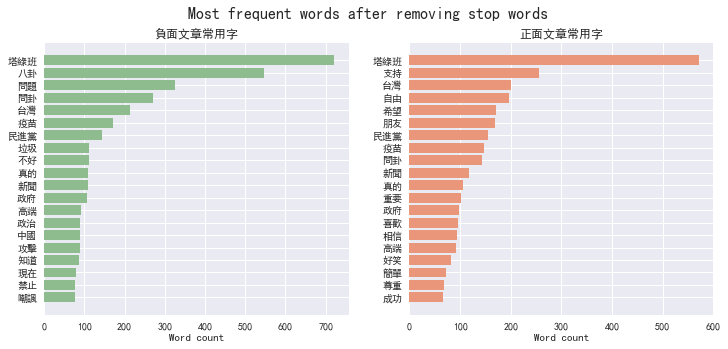

In [71]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()

可以看到正面文章出現的詞有「支持」、「自由」、「喜歡」、「尊重」、「成功」等詞彙，負面文章則出現「問題」、「不好」、「攻擊」、「禁止」等詞彙，甚至出現謾罵的「垃圾」等字眼。而「疫苗」、「民進黨」則因為是話題焦點，在兩邊的文章都頻繁出現。

## 3. 將資料切成訓練集與測試集
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [72]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [73]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
neu    80.373196
neg    10.478205
pos     9.148599
Name: label, dtype: float64

train percentage :
neu    80.371983
neg    10.479548
pos     9.148469
Name: label, dtype: float64

test percentage :
neu    80.376028
neg    10.475071
pos     9.148900
Name: label, dtype: float64


## 4. 將文章轉為 DTM
+ 4.1 簡單範例介紹DTM
+ 4.2 套入正式資料集訓練

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)
    + ngram_range: unigrams and bigrams

### 4.1 簡單範例介紹DTM

在這裡我們用簡單的四個中文句子，建立一個 DTM，在這裡我們利用 `CountVectorizer` 計算出不同句子的詞頻，再轉換成DTM。DTM裡面每個row代表一個句子，每個column代表一個詞出現的次數，在這邊我們可以設定`ngram_range`參數，讓句子考慮到前後單詞的組合。

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
     '塔綠斑 塔綠斑 塔綠斑',
     '民進黨 塔綠斑',
     '國民黨 民進黨 假新聞',
     '國民黨 民進黨',
]
vectorizer = CountVectorizer() # ngram_range=(1, 2)
X = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()

# 轉成dataframe來看
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

print(f"documents: {X.shape[0]} terms: {X.shape[1]}")
print(f"\nterms:\n {vocabulary}") # DTM 字詞可以藉由 get_feature_names 查看
print(f"\nDTM array:\n {X.toarray()}") # DTM的資料結構，裡面代表字詞的頻率
DTM_df

documents: 4 terms: 4

terms:
 ['假新聞', '國民黨', '塔綠斑', '民進黨']

DTM array:
 [[0 0 3 0]
 [0 0 1 1]
 [1 1 0 1]
 [0 1 0 1]]


,假新聞,國民黨,塔綠斑,民進黨
0,0,0,3,0
1,0,0,1,1
2,1,1,0,1
3,0,1,0,1


### 4.2 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [75]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000,min_df = 10) # , ngram_range=(1,2)

# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100) # , ngram_range=(1,2)

In [76]:
corpus = dtf_train["clean_txt"]

+ 過濾詞頻比較

In [77]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

In [78]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 
X_train

without term cut off: posts 27797 words: 10000 (10000)
with term cut off: posts 27797 words: 1541 (1541)


<27797x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 80861 stored elements in Compressed Sparse Row format>

In [79]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [80]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/home/ann2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.95
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.76      0.85      1248
         neu       0.95      1.00      0.97      9576
         pos       0.99      0.78      0.87      1090

    accuracy                           0.95     11914
   macro avg       0.97      0.85      0.90     11914
weighted avg       0.96      0.95      0.95     11914



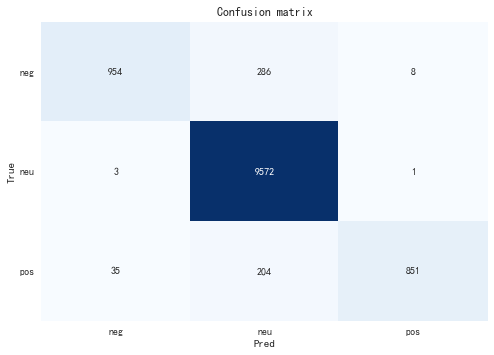

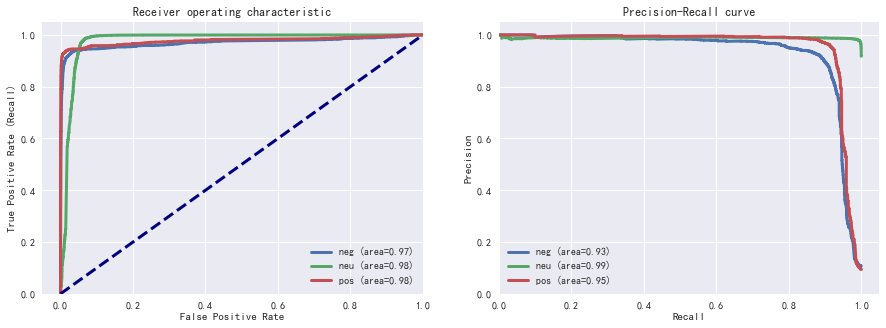

In [81]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [82]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/home/ann2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.94
Auc: 0.9
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.70      0.81      1248
         neu       0.94      1.00      0.97      9576
         pos       0.98      0.73      0.83      1090

    accuracy                           0.94     11914
   macro avg       0.96      0.81      0.87     11914
weighted avg       0.94      0.94      0.94     11914



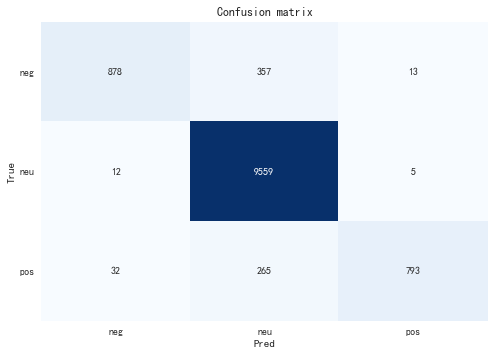

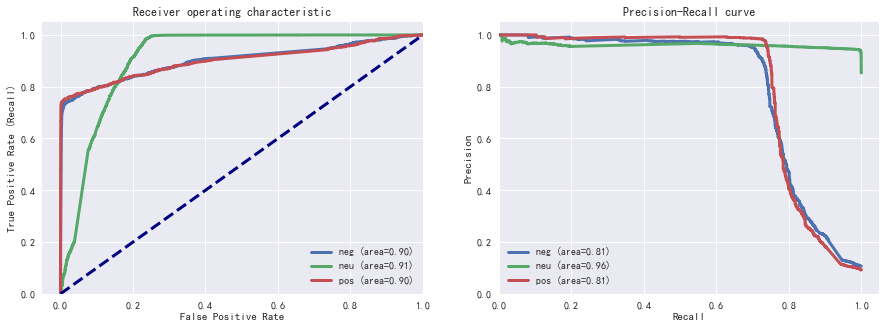

In [83]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

可以看到過濾詞頻之後，字詞的維度減少，不過準確度也稍微下降了，同學可以自行嘗試是否依據詞頻過濾，或調整詞頻過濾的大小，看看模型的準確度會有什麼樣的變化

### 4.3. 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

In [84]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [85]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

ROC 適用二元分類，故將每個類別(正面、中性、負面情緒)的預測都視作為一個二元分類，以下比較上面各模型的分類效果

### step 1 定義 vectorizer

In [86]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

### step 2 定義 classifier

In [87]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### step 3 定義測試和訓練資料集

In [88]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [89]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

## 5.比較不同模型和資料組合的訓練結果

### 5.1 Model Building : logistic regression
logistic regression 原本是用來做二元分類的，如果要多元分類需要另外指定
+ 預設是預測二元分布(binomial probability)的機率，需要改為多元分布(multinomial probability)
+ [參考: Multinomial Logistic Regression With Python](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/)

model type: CV + logistic regression


/home/ann2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


time costing: 2.5843448638916016
Accuracy: 0.95
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.76      0.85      1248
         neu       0.95      1.00      0.97      9576
         pos       0.99      0.78      0.87      1090

    accuracy                           0.95     11914
   macro avg       0.97      0.85      0.90     11914
weighted avg       0.96      0.95      0.95     11914



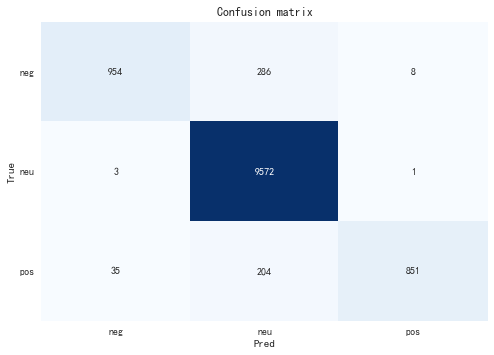

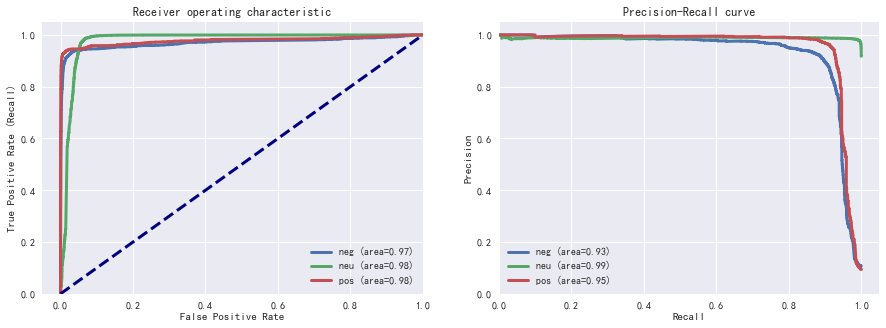

In [90]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression


/home/ann2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


time costing: 2.308095932006836
Accuracy: 0.92
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.58      0.72      1248
         neu       0.91      1.00      0.95      9576
         pos       0.99      0.62      0.77      1090

    accuracy                           0.92     11914
   macro avg       0.96      0.73      0.81     11914
weighted avg       0.93      0.92      0.91     11914



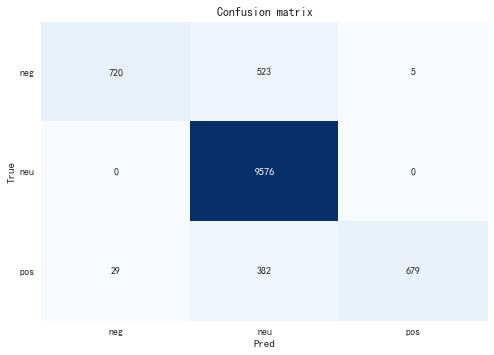

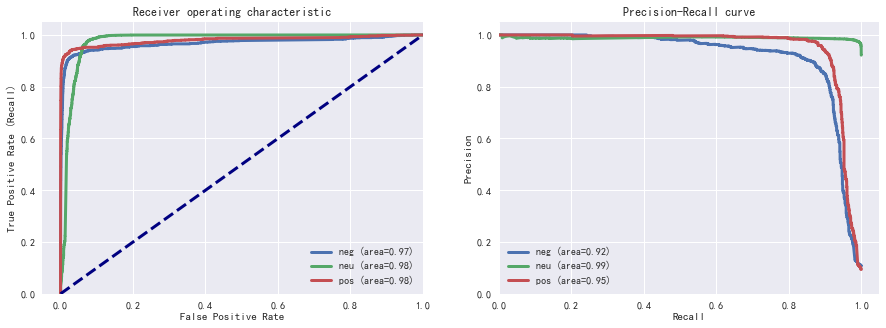

In [91]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.2 Model Building : SVC

model type: CV + SVC
time costing: 380.19286012649536
Accuracy: 0.91
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.52      0.68      1248
         neu       0.90      1.00      0.95      9576
         pos       0.99      0.53      0.69      1090

    accuracy                           0.91     11914
   macro avg       0.95      0.68      0.77     11914
weighted avg       0.91      0.91      0.89     11914



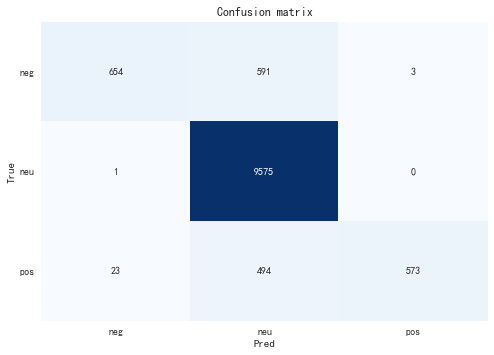

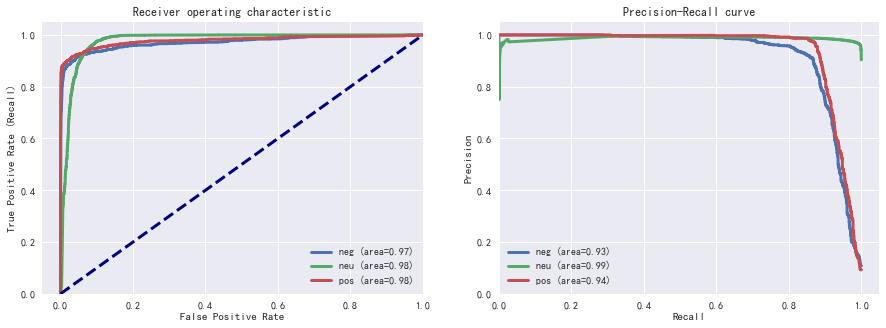

In [92]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 452.051233291626
Accuracy: 0.93
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.97      0.62      0.75      1248
         neu       0.92      1.00      0.96      9576
         pos       1.00      0.66      0.79      1090

    accuracy                           0.93     11914
   macro avg       0.96      0.76      0.84     11914
weighted avg       0.93      0.93      0.92     11914



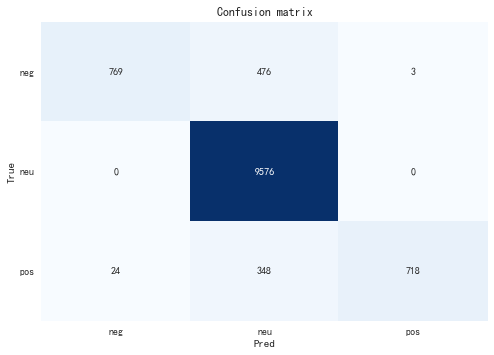

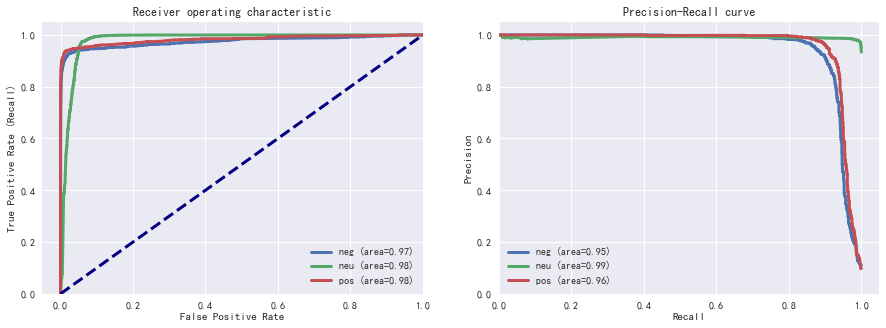

In [93]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.3 Model Building : RandomForest

model type: CV + RandomForest
time costing: 19.943699836730957
Accuracy: 0.98
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.90      0.93      1248
         neu       0.98      1.00      0.99      9576
         pos       0.98      0.89      0.94      1090

    accuracy                           0.98     11914
   macro avg       0.97      0.93      0.95     11914
weighted avg       0.98      0.98      0.98     11914



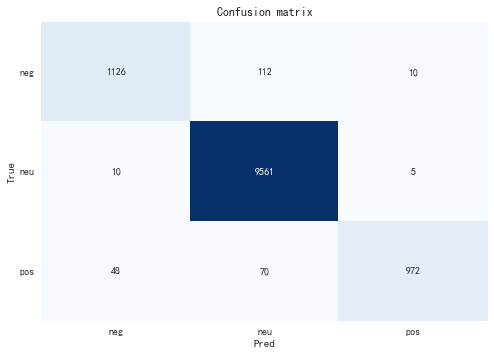

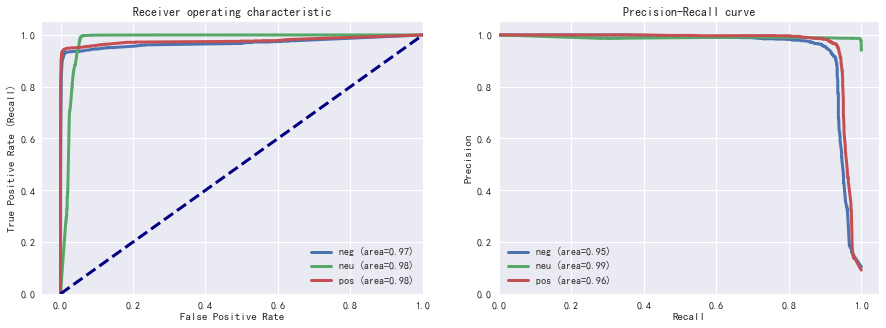

In [94]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 19.46518874168396
Accuracy: 0.98
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.89      0.92      1248
         neu       0.98      1.00      0.99      9576
         pos       0.99      0.89      0.93      1090

    accuracy                           0.98     11914
   macro avg       0.97      0.92      0.95     11914
weighted avg       0.98      0.98      0.98     11914



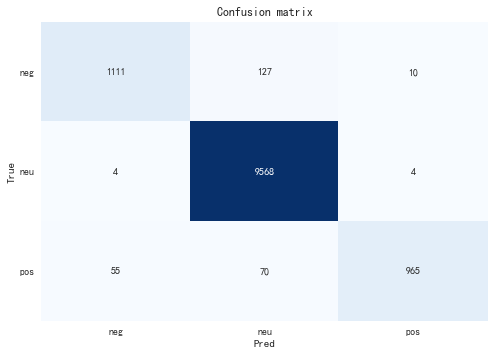

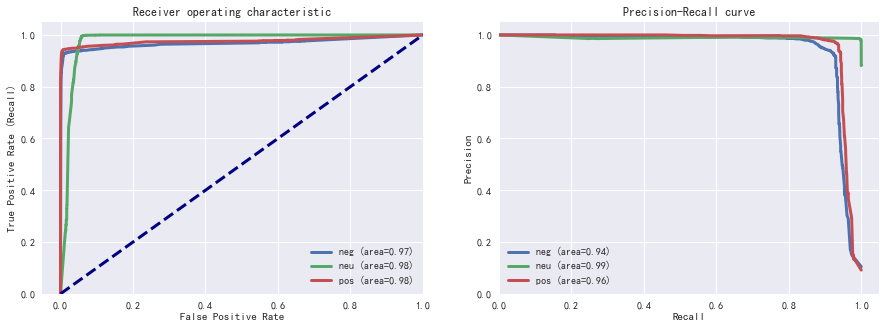

In [95]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.4 預測結果探索
+ 5.4.1 各字詞特徵的estimate係數
+ 5.4.2 查看分類錯誤的句子
+ 5.4.3 比較不同模型的ROC

查看模型預測結果

In [96]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
4,CV + RandomForest,0.978597,0.974905
5,TF-IDF + RandomForest,0.977338,0.974428
0,CV + logistic regression,0.954927,0.975105
3,TF-IDF + SVC,0.928571,0.978925
1,TF-IDF + logistic regression,0.921185,0.974617
2,CV + SVC,0.906664,0.975677


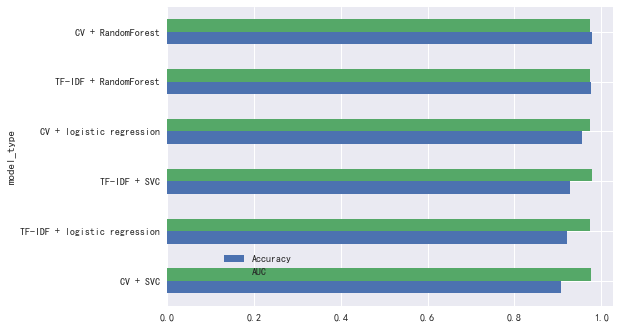

In [97]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

可以看到效果最好得組合是tf-idf，加上隨機森林的模型

### 5.4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 5.1 的 logistic regression + cv tokenizer 為例

In [98]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [99]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

,neg,neu,pos
一一,-0.003743,-0.058870,0.059304
一丁,-0.087743,0.100565,0.257052
一下,-0.166599,-0.218692,0.207310
一下子,-0.103334,-0.140276,-0.115367
一中,0.001726,0.175635,-0.017301


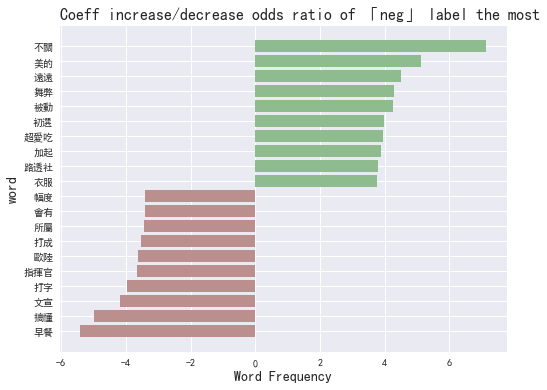

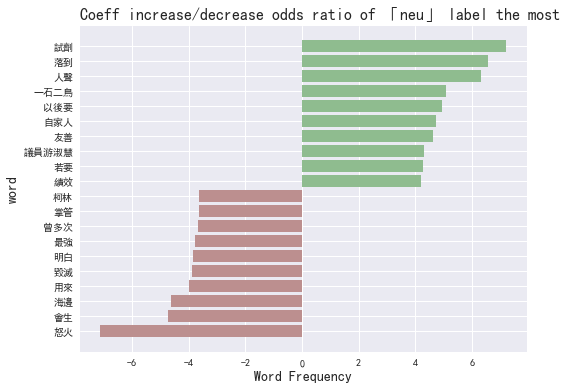

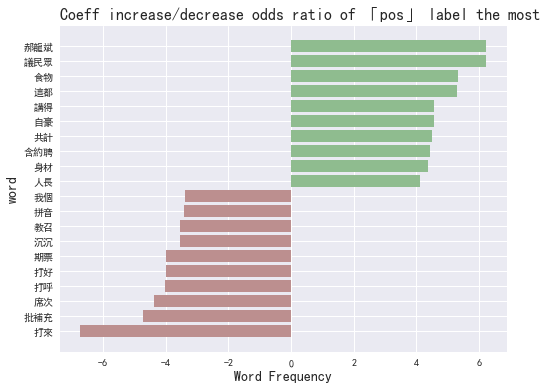

In [100]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

「舞弊」、「被動」 等字是影響判斷為負面情緒的重要字；「自豪」字是影響判斷為正面句子的重要字詞。

### 看一下含特定關鍵字的句子

In [101]:
keyword_list = ['染疫','消失','提案'] 
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(10)

,document,sentence,artUrl,label
641,641,然後3+11造成800多人染疫枉死,https://www.ptt.cc/bbs/Gossiping/M.1630473052....,neg
990,990,幸運染疫死的話,https://www.ptt.cc/bbs/Gossiping/M.1630489703....,neu
1707,1707,#讓復必泰在台灣消失,https://www.ptt.cc/bbs/Gossiping/M.1630556729....,neu
1709,1709,打完復必泰就消失了 自己還有抗體,https://www.ptt.cc/bbs/Gossiping/M.1630556729....,neu
1762,1762,Re:[新聞]復必泰布條出艙前消失地勤人員一動作曝把布條拿掉 真的是很無言,https://www.ptt.cc/bbs/Gossiping/M.1630558268....,neu
2097,2097,或是到時候自己的提案沒通過就要開始在媒體上面洗,https://www.ptt.cc/bbs/Gossiping/M.1630571902....,neu
2876,2876,至於會不會讓目前染疫0死亡的22歲以下族群因疫苗而死，跟經濟比都是次要的，誰反對,https://www.ptt.cc/bbs/Gossiping/M.1630640081....,neg
2912,2912,為何不提案直接14+0,https://www.ptt.cc/bbs/Gossiping/M.1630645073....,neu
2987,2987,可惜這次染疫人員離聖地邁家還很遠，無法靠宗教力量和堵藍經對抗疫苗，阿不是，是對,https://www.ptt.cc/bbs/Gossiping/M.1630647664....,neg
3589,3589,之前塔綠班也在宣傳有個高端受測者和Delta同桌沒有染疫,https://www.ptt.cc/bbs/Gossiping/M.1630674807....,neu


### 5.4.2 查看分類錯誤的句子

In [102]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 125
neg label predicted wrong: 137
neu label predicted wrong: 8


/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


看一下都是什麼樣的句子分錯

In [103]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
11088,你有阿富汗塔利班這種就算只有輕兵器 也要打贏敵人的決心嗎,https://www.ptt.cc/bbs/Gossiping/M.1631393197....,pos,neg
13212,強壯的人都打到疫苗了,https://www.ptt.cc/bbs/Gossiping/M.1631588018....,pos,neu
12898,司法院已提出《涉外民事適用法》修正草案，以解決跨國同性伴侶結婚問題，,https://www.ptt.cc/bbs/Gossiping/M.1631535537....,pos,neg
36400,其實大陸飛機來 也沒什麼了不起 根本不需要緊張,https://www.ptt.cc/bbs/Gossiping/M.1632394329....,pos,neg
10771,相反的如果操控的不好，聲望就容易歸零，跟塔綠班一樣...賭到聲望值歸零！,https://www.ptt.cc/bbs/Gossiping/M.1631355333....,pos,neg


In [104]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
14188,要怎麼預防盛行，戴口罩還是封城有辦法預防Delta綠班的侵襲嗎,https://www.ptt.cc/bbs/Gossiping/M.1631677630....,neg,neu
36321,」而且表情絕望......,https://www.ptt.cc/bbs/Gossiping/M.1632393813....,neg,neu
33333,發中亞洲對於新冠病毒疫情依然脆弱。,https://www.ptt.cc/bbs/Gossiping/M.1632302646....,neg,neu
19213,變動大，之後會怎麼樣，誰也說不準」，議員不死心換個方法問,https://www.ptt.cc/bbs/Gossiping/M.1631880822....,neg,neu
29294,Re:[問卦]隔壁塔綠班鄰居跑去打高端該怎麼嘲笑別這樣，人家至少言行一致，要尊重他，怎好嘲笑他呢？,https://www.ptt.cc/bbs/Gossiping/M.1632205100....,neg,pos


In [105]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
15422,還有就是，你是不是把塔利班就同等於伊斯蘭教、或是回教的教派就只有塔利班能代表!,https://www.ptt.cc/bbs/Gossiping/M.1631766577....,neu,neg
31799,我們都知道伊斯蘭教這兩個互看不順眼,https://www.ptt.cc/bbs/Gossiping/M.1632239710....,neu,neg
13140,朱學恒表示：「身為一個納稅人，小弟一直覺得你在德國沒有很認真地盡到增進台德關係的,https://www.ptt.cc/bbs/Gossiping/M.1631581926....,neu,pos
27793,我484應該對於我的認知乏弱感到愧疚,https://www.ptt.cc/bbs/Gossiping/M.1632197254....,neu,neg
32231,難怪在台北市的3+11機師感到處亂跑帶妹妹喝酒,https://www.ptt.cc/bbs/Gossiping/M.1632278842....,neu,neg


觀察模型分類效果，若一開始標註情況不佳，可以依據分類結果修改情緒字典

### 5.4.3 比較不同模型的ROC

ROC 只適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果

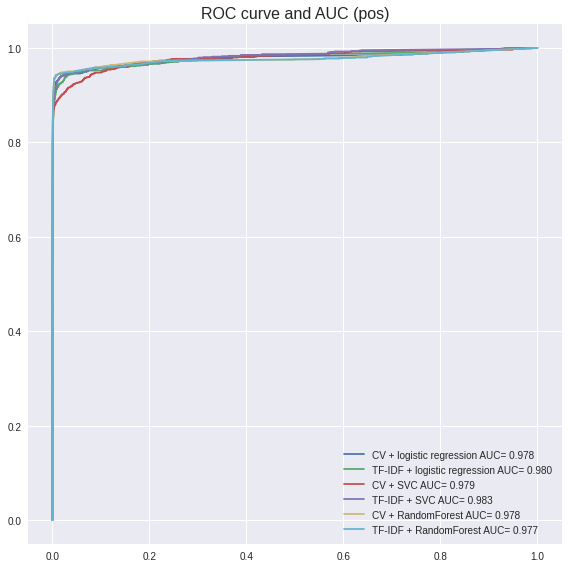

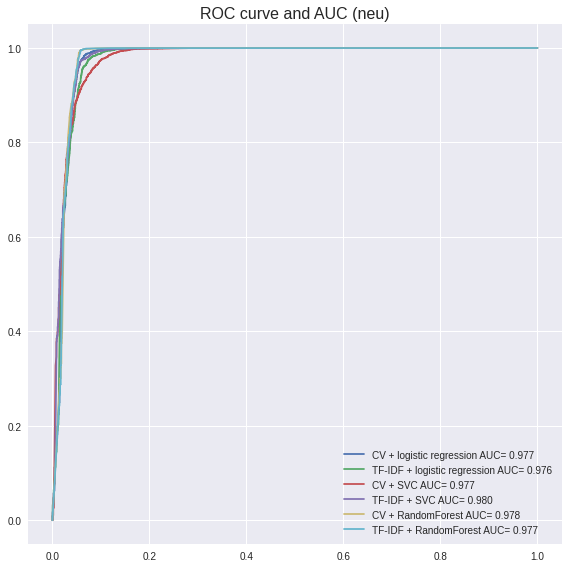

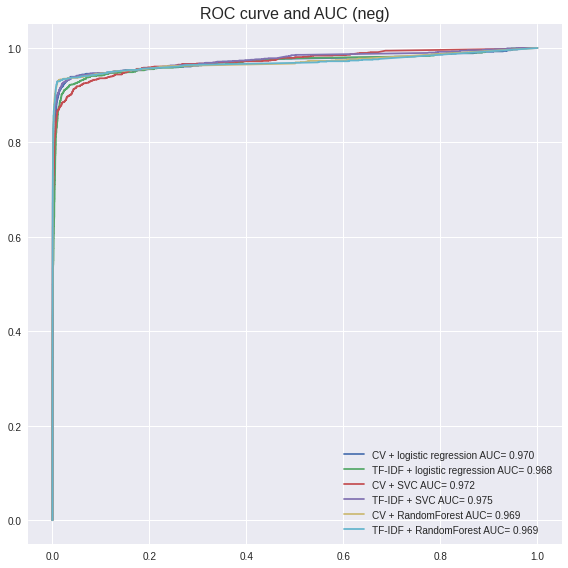

In [106]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

accuracy可能會因為正負面資料分布不同而有所偏差，所以選擇模型的時候，可以加入一起 AUC 評估。在這裡可以看到個模型在三種情緒的AUC指標都不會相差太多，對於AUC來說，整體而言 TF-IDF + SVC 的表現較好。若以準確率來看，CV + RandomForest 表現最好。

## 結論
1. 各情緒的字詞分佈有甚麼不同，代表字詞有哪些？
    + 初步用詞頻探索發現，可以看到正面文章出現的詞有「支持」、「自由」、「喜歡」、「尊重」、「成功」等詞彙，負面文章則出現「問題」、「不好」、「攻擊」、「禁止」等詞彙，甚至出現謾罵的「垃圾」等字眼。而「疫苗」、「民進黨」則因為是話題焦點，在兩邊的文章都頻繁出現。建模後觀察「舞弊」、「被動」 等字是影響判斷為負面情緒的重要字；「自豪」字是影響判斷為正面句子的重要字詞。
2. 如果用詞頻建立DTM，需不需要篩選詞頻？
    + 經由 4.2 的實驗發現，不篩詞頻模型會比較準，但需要較長的時間，同學可以自行取捨
3. 此資料集用什麼樣的模型預測，準確率會較高？
    + 模型在三種情緒的AUC指標都不會相差太多，整體而言除了正面情緒 CV + logistic 外，TF-IDF + SVC 的表現較好。